<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Var" data-toc-modified-id="Var-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Var</a></span></li><li><span><a href="#Init" data-toc-modified-id="Init-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Init</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load</a></span><ul class="toc-item"><li><span><a href="#Format" data-toc-modified-id="Format-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Format</a></span></li><li><span><a href="#Filtering" data-toc-modified-id="Filtering-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Filtering</a></span></li></ul></li><li><span><a href="#Plotting" data-toc-modified-id="Plotting-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plotting</a></span></li><li><span><a href="#Tree-subsample" data-toc-modified-id="Tree-subsample-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Tree subsample</a></span></li><li><span><a href="#RRPP" data-toc-modified-id="RRPP-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>RRPP</a></span><ul class="toc-item"><li><span><a href="#Summary" data-toc-modified-id="Summary-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Summary</a></span></li></ul></li><li><span><a href="#RRPP:-no-phy-cov" data-toc-modified-id="RRPP:-no-phy-cov-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>RRPP: no phy-cov</a></span><ul class="toc-item"><li><span><a href="#RRPP" data-toc-modified-id="RRPP-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>RRPP</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Summary</a></span></li></ul></li><li><span><a href="#sessionInfo" data-toc-modified-id="sessionInfo-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>sessionInfo</a></span></li></ul></div>

# Goal

* RRPP analysis to assess correlations of OTUs and host phenotypes while controlling for host phylogeny
* Just assessing Methanobrevibacter ASVs versus body temperature

# Var

In [1]:
work_dir = '/ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/modulating/RRPP/'

# microbiome
## 16S-arch phyloseq object (one sample per individual)
physeq_arch_IndD_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/merged/phyloseq/physeq_arch_IndD_rare250.RDS'

# host tree
host_tree_IndD_file = '/ebio/abt3_projects/Georg_animal_feces/data/animal/phylogeny/TT/unified_metadata_complete_200429_16S-arch_IndD.nwk'

# body temp data
Tb_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/merged//bodyTemp_all.tsv'

# misc params
threads = 12
my_seed = 8394

# Init

In [2]:
library(dplyr)
library(tidyr)
library(ggplot2)

library(ape)
library(phyloseq)
library(RRPP)

library(doParallel)
library(LeyLabRMisc)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘RRPP’


The following object is masked from ‘package:phyloseq’:

    ordinate


Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



In [3]:
# cluster job submission
#clustermq_setup()
#library(clustermq)

In [4]:
df.dims()
set.seed(my_seed)
make_dir(work_dir)
RhpcBLASctl::blas_set_num_threads(1)

Directory already exists: /ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/modulating/RRPP/ 


# Load

In [5]:
# phyloseq obj.
physeq = readRDS(physeq_arch_IndD_file) %>%
    subset_taxa(Order == 'Methanobacteriales') %>%
    subset_taxa(Genus != 'unclassified') %>%
    tax_glom(taxrank='Genus') %>%
    filter_taxa(function(x) sum(x > 0) >= 2, TRUE) %>%
    prune_samples(sample_sums(.) > 0, .) 
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 5 taxa and 181 samples ]
sample_data() Sample Data:       [ 181 samples by 88 sample variables ]
tax_table()   Taxonomy Table:    [ 5 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 5 tips and 4 internal nodes ]

In [6]:
# otu table
otu = physeq %>%
    phyloseq2df(otu_table) %>%
    as.data.frame
rownames(otu) = otu$OTU
otu$OTU = NULL
otu = otu %>% t %>% as.data.frame
colnames(otu) = gsub('^([0-9])', 'X_\\1', colnames(otu))
otu

,X_4ac642f8f9177a31724b3c4872792524,b4b7f7c4e6fd5610c4c1fa696408159e,X_859b0f9281126ff8d74d751373fd8891,X_1f1f87cab902b66753b8bbd81e69a7d4,X_250a31c11dbecf1e2ef705424fdaa7a7
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F14_Common_Bream,0,0.8,0,0,73.6
F35_Red_Deer,0,48.4,0,16,0.0
⋮,⋮,⋮,⋮,⋮,⋮
X431_Quagga,0,1.6,0,0.0,0
X67_European_Roe,0,98.4,0,1.6,0


In [7]:
# host phylogeny
host_tree = read.tree(host_tree_IndD_file)
host_tree


Phylogenetic tree with 185 tips and 184 internal nodes.

Tip labels:
	X60_European_Chub, X179_Roach, X330_Ide, X327_Silver_Bream, X326_Silver_Bream, F14_Common_Bream, ...
Node labels:
	, @_20_@, @_17_@, @_14_@, @_9_@, @_15_@, ...

Rooted; includes branch lengths.

In [8]:
# metadata
metadata = physeq %>% 
    phyloseq2df(sample_data) %>%
    mutate(scientific_name = gsub(' ', '_', scientific_name),
           digestive_system = gsub('fermentation activity ', '', digestive_system),
           dig_sys = gsub('simple ', '', digestive_system)) %>%
    as.data.frame
rownames(metadata) = metadata$SampleID
metadata 

,SampleID,host_subject_id,host_german_name,host_common_name,scientific_name,scientific_name_subspecies,host_taxid,class,order,family,⋯,i.CH4_L.d_mean,i.CH4_L.d_sd,i.CH4_L.kgBM_mean,i.CH4_L.kgBM_sd,i.CH4_g.d_mean,i.CH4_g.d_sd,i.CH4_kJ.d_mean,i.CH4_kJ.d_sd,Sample,dig_sys
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
F14_Common_Bream,F14_Common_Bream,F14,Brachse,Common.Bream,Abramis_brama,NA,38527,Actinopterygii,Cypriniformes,Cyprinidae,⋯,NA,NA,NA,NA,NA,NA,NA,NA,F14_Common_Bream,simple
F35_Red_Deer,F35_Red_Deer,F35,Rothirsch,Red.Deer,Cervus_elaphus,NA,9860,Mammalia,Artiodactyla,Cervidae,⋯,52.24132,27.18306,0.4858472,0.1686955,38.67117,21.30162,2066.942,1075.505,F35_Red_Deer,foregut
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
X431_Quagga,X431_Quagga,431,Steppenzebra,Quagga,Equus_quagga,NA,89252,Mammalia,Perissodactyla,Equidae,⋯,NA,NA,NA,NA,NA,NA,NA,NA,X431_Quagga,hindgut
X67_European_Roe,X67_European_Roe,67,Reh,European.Roe,Capreolus_capreolus,NA,9858,Mammalia,Artiodactyla,Cervidae,⋯,NA,NA,NA,NA,NA,NA,NA,NA,X67_European_Roe,foregut


In [9]:
# adding body temp
metadata = metadata %>%
    inner_join(read.delim(Tb_file) %>% 
                   dplyr::select(scientific_name, dataset, Tb) %>%
                   mutate(scientific_name = gsub(' ', '_', scientific_name)),
               c('scientific_name')) %>%
    rename('dataset_Tb' = dataset)

metadata %>% .$Tb %>% summary_x
metadata 

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,NA's,sd,sd_err_of_mean
.,30.7,37.425,38.6,38.30797,39.575,42.3,43,4.039,1.526


SampleID,host_subject_id,host_german_name,host_common_name,scientific_name,scientific_name_subspecies,host_taxid,class,order,family,⋯,i.CH4_L.kgBM_mean,i.CH4_L.kgBM_sd,i.CH4_g.d_mean,i.CH4_g.d_sd,i.CH4_kJ.d_mean,i.CH4_kJ.d_sd,Sample,dig_sys,dataset_Tb,Tb
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
F14_Common_Bream,F14,Brachse,Common.Bream,Abramis_brama,NA,38527,Actinopterygii,Cypriniformes,Cyprinidae,⋯,NA,NA,NA,NA,NA,NA,F14_Common_Bream,simple,NA,NA
F35_Red_Deer,F35,Rothirsch,Red.Deer,Cervus_elaphus,NA,9860,Mammalia,Artiodactyla,Cervidae,⋯,0.4858472,0.1686955,38.67117,21.30162,2066.942,1075.505,F35_Red_Deer,foregut,WalzerXXXX,38.6
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
X431_Quagga,431,Steppenzebra,Quagga,Equus_quagga,NA,89252,Mammalia,Perissodactyla,Equidae,⋯,NA,NA,NA,NA,NA,NA,X431_Quagga,hindgut,NA,NA
X67_European_Roe,67,Reh,European.Roe,Capreolus_capreolus,NA,9858,Mammalia,Artiodactyla,Cervidae,⋯,NA,NA,NA,NA,NA,NA,X67_European_Roe,foregut,WalzerXXXX,40.4


## Format

In [10]:
vars = c('Tb')
otu = cbind(metadata[,vars, drop=FALSE], otu)
otu

,Tb,X_4ac642f8f9177a31724b3c4872792524,b4b7f7c4e6fd5610c4c1fa696408159e,X_859b0f9281126ff8d74d751373fd8891,X_1f1f87cab902b66753b8bbd81e69a7d4,X_250a31c11dbecf1e2ef705424fdaa7a7
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F14_Common_Bream,NA,0,0.8,0,0,73.6
F35_Red_Deer,38.6,0,48.4,0,16,0.0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
X431_Quagga,NA,0,1.6,0,0.0,0
X67_European_Roe,40.4,0,98.4,0,1.6,0


## Filtering

In [11]:
# filtering otu
otu = otu[!is.na(otu$Tb),]
otu

,Tb,X_4ac642f8f9177a31724b3c4872792524,b4b7f7c4e6fd5610c4c1fa696408159e,X_859b0f9281126ff8d74d751373fd8891,X_1f1f87cab902b66753b8bbd81e69a7d4,X_250a31c11dbecf1e2ef705424fdaa7a7
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F35_Red_Deer,38.6,0,48.4,0,16.0,0
F36_Red_Deer,38.6,0,93.2,0,6.8,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
X403_Chacma_Baboon,37.0,0,4.0,0,0.0,0
X67_European_Roe,40.4,0,98.4,0,1.6,0


In [12]:
# sparsity
prev = apply(otu[,2:ncol(otu)], 2, function(x) sum(x > 0) / length(x) * 100)
to_keep = c('Tb', names(prev[prev >= 5]))
otu = otu[,to_keep]
otu

,Tb,b4b7f7c4e6fd5610c4c1fa696408159e,X_859b0f9281126ff8d74d751373fd8891,X_1f1f87cab902b66753b8bbd81e69a7d4
,<dbl>,<dbl>,<dbl>,<dbl>
F35_Red_Deer,38.6,48.4,0,16.0
F36_Red_Deer,38.6,93.2,0,6.8
⋮,⋮,⋮,⋮,⋮
X403_Chacma_Baboon,37.0,4.0,0,0.0
X67_European_Roe,40.4,98.4,0,1.6


In [13]:
# filtering tree
to_rm = setdiff(host_tree$tip.label, rownames(otu))
host_tree = ape::drop.tip(host_tree, to_rm)
host_tree


Phylogenetic tree with 138 tips and 137 internal nodes.

Tip labels:
	X372_Emu, X33_Wild_Turkey, X131_Rock_Ptarmigan, X31_Chicken, X271_Common_Pheasant, X270_Common_Pheasant, ...
Node labels:
	@_196_@, @_89_@, @_88_@, @_46_@, @_40_@, @_38_@, ...

Rooted; includes branch lengths.

In [14]:
# checking overlap
overlap(host_tree$tip.label, rownames(otu))

intersect(x,y): 138 
setdiff(x,y): 0 
setdiff(y,x): 0 
union(x,y): 138 


# Plotting

In [15]:
tax = physeq %>%
    phyloseq2df(tax_table) %>%
    mutate(OTU = gsub('^([0-9])', 'X_\\1', OTU))

df.dims(20)
tax
df.dims()

Domain,Phylum,Class,Order,Family,Genus,Species,OTU
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,uncultured,NA,X_4ac642f8f9177a31724b3c4872792524
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,NA,b4b7f7c4e6fd5610c4c1fa696408159e
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanothermobacteraceae,Methanothermobacter,NA,X_859b0f9281126ff8d74d751373fd8891
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanosphaera,NA,X_1f1f87cab902b66753b8bbd81e69a7d4
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobacterium,NA,X_250a31c11dbecf1e2ef705424fdaa7a7


In [16]:
# joining
otu_j = otu %>%
    mutate(Sample = rownames(.)) %>%
    gather(OTU, perc_abund, -Tb, -Sample) %>%
    dplyr::select(-Tb) %>%
    inner_join(metadata, c('Sample'='SampleID')) %>%
    inner_join(tax, c('OTU')) %>%
    filter(!is.na(Tb))
otu_j

Sample,OTU,perc_abund,host_subject_id,host_german_name,host_common_name,scientific_name,scientific_name_subspecies,host_taxid,class,⋯,dig_sys,dataset_Tb,Tb,Domain,Phylum,Class,Order,Family,Genus,Species
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,⋯,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
F35_Red_Deer,b4b7f7c4e6fd5610c4c1fa696408159e,48.4,F35,Rothirsch,Red.Deer,Cervus_elaphus,NA,9860,Mammalia,⋯,foregut,WalzerXXXX,38.6,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,NA
F36_Red_Deer,b4b7f7c4e6fd5610c4c1fa696408159e,93.2,F36,Rothirsch,Red.Deer,Cervus_elaphus,NA,9860,Mammalia,⋯,foregut,WalzerXXXX,38.6,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
X403_Chacma_Baboon,X_1f1f87cab902b66753b8bbd81e69a7d4,0.0,403,Baerenpavian,Chacma.Baboon,Papio_ursinus,NA,36229,Mammalia,⋯,simple,Sieg2009,37.0,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanosphaera,NA
X67_European_Roe,X_1f1f87cab902b66753b8bbd81e69a7d4,1.6,67,Reh,European.Roe,Capreolus_capreolus,NA,9858,Mammalia,⋯,foregut,WalzerXXXX,40.4,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanosphaera,NA


`geom_smooth()` using formula 'y ~ x'



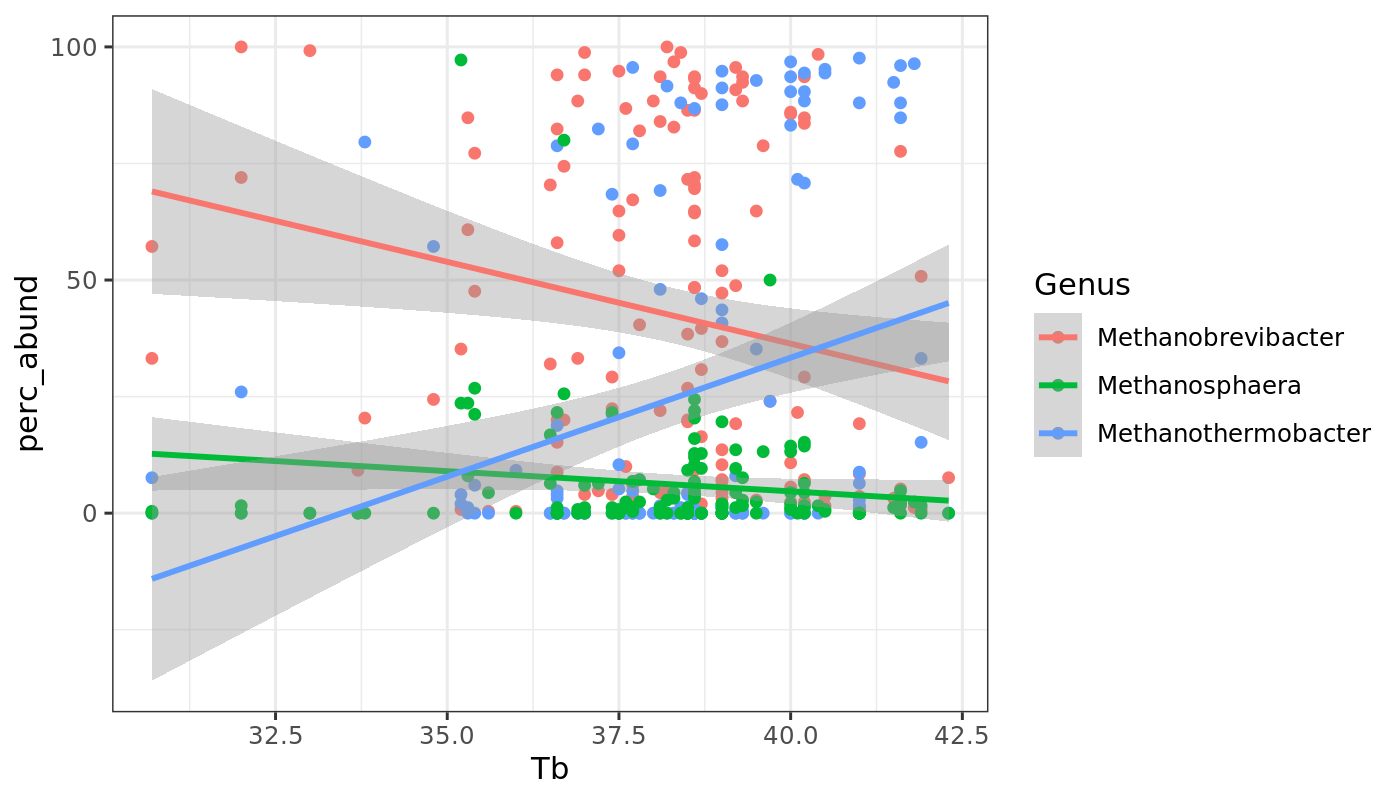

In [17]:
# plotting
p = otu_j %>%
    ggplot(aes(Tb, perc_abund, color=Genus)) +
    geom_point() +
    geom_smooth(method='lm') +
    theme_bw()

p.dims(7,4)
plot(p)

`geom_smooth()` using formula 'y ~ x'



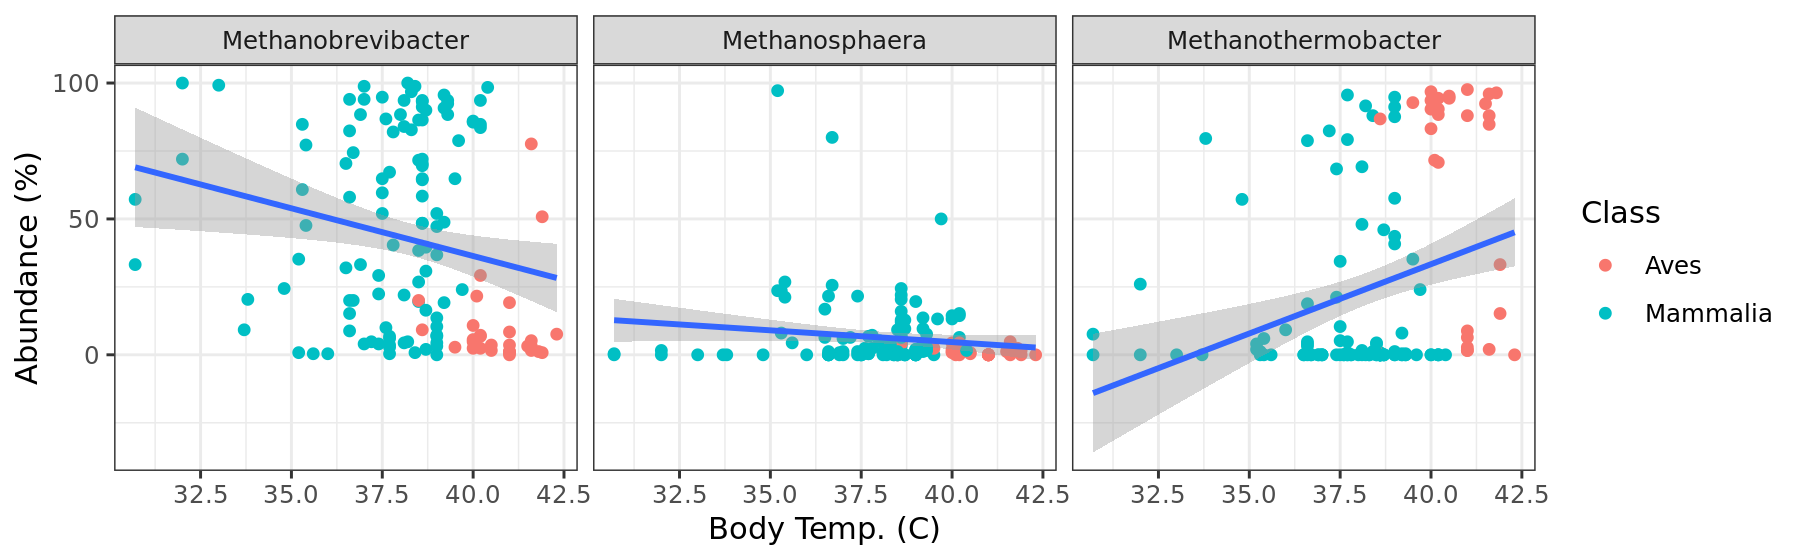

In [40]:
# plotting
p = otu_j %>%
    ggplot(aes(Tb, perc_abund)) +
    geom_point(aes(color=class)) +
    geom_smooth(method='lm') +
    scale_color_discrete('Class') +
    labs(x='Body Temp. (C)', y='Abundance (%)') +
    facet_wrap(~ Genus) +
    theme_bw()

p.dims(9,2.8)
plot(p)

`geom_smooth()` using formula 'y ~ x'



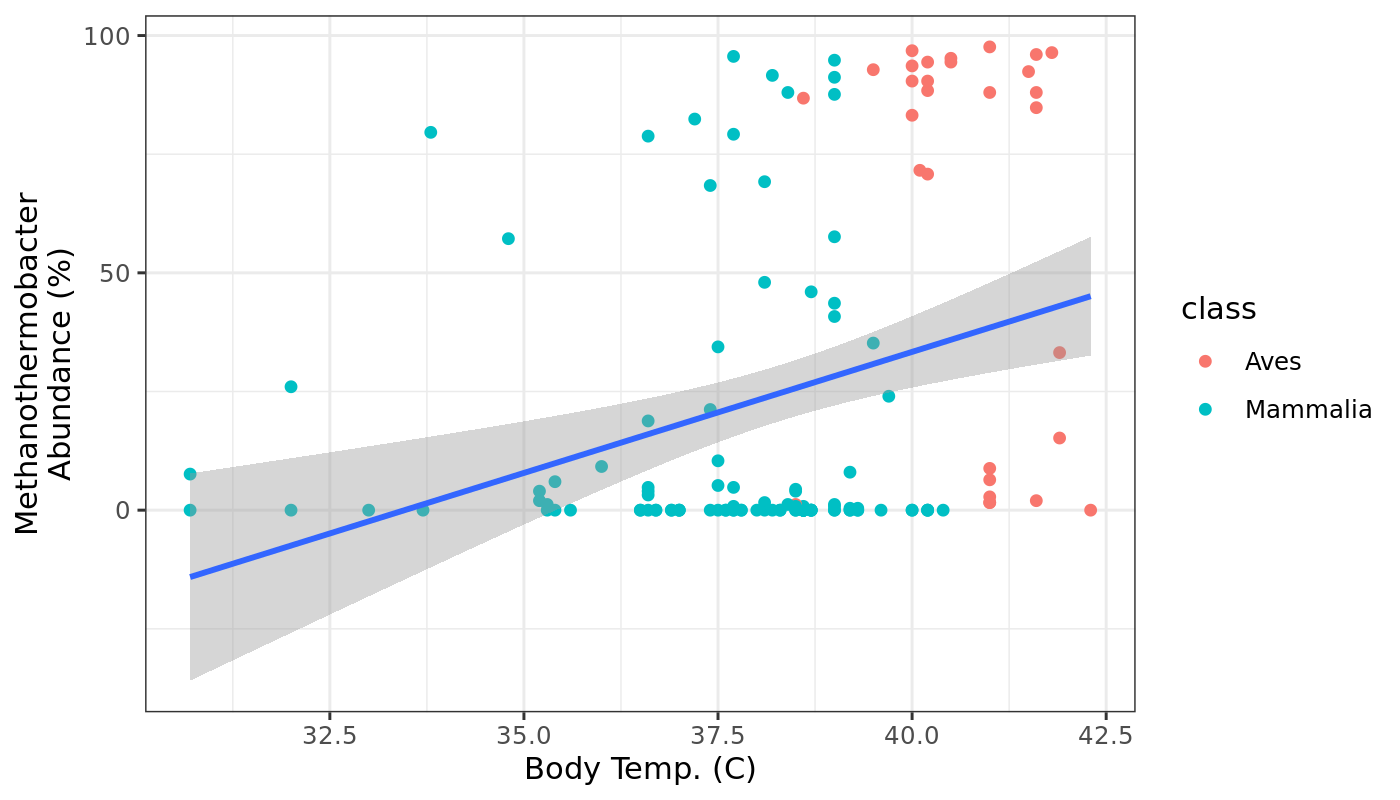

In [19]:
# plotting
p = otu_j %>%
    filter(Genus == 'Methanothermobacter') %>%
    ggplot(aes(Tb, perc_abund)) +
    geom_point(aes(color=class)) +
    geom_smooth(method='lm') +
    labs(x='Body Temp. (C)', y='Methanothermobacter\nAbundance (%)') +
    theme_bw()

p.dims(7,4)
plot(p)

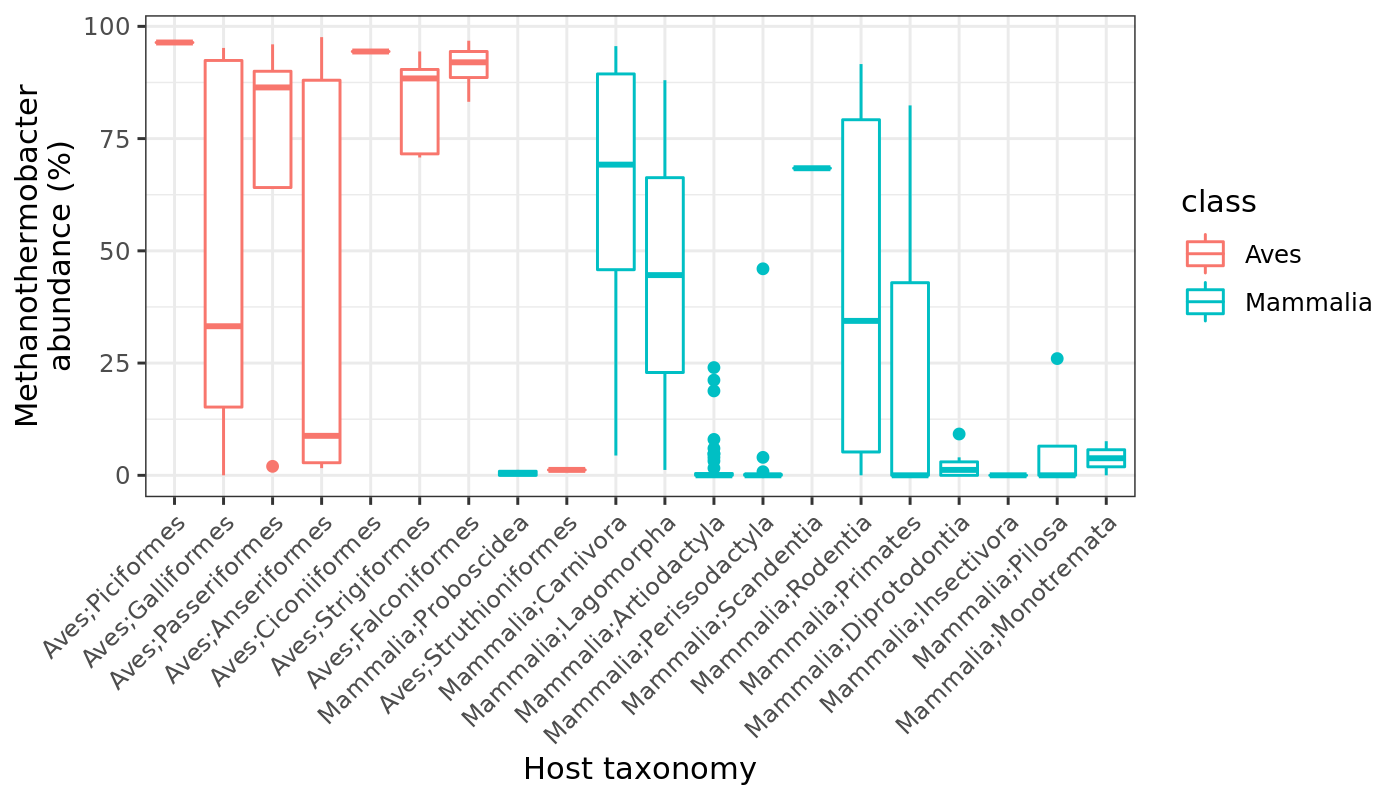

In [20]:
# plotting
p = otu_j %>%
    mutate(host_tax = paste(class, order, sep=';')) %>%
    group_by(host_tax) %>%
    mutate(mean_Tb = mean(Tb)) %>%
    ungroup() %>%
    filter(Genus == 'Methanothermobacter') %>%
    mutate(host_tax = host_tax %>% reorder(-mean_Tb)) %>%
    ggplot(aes(host_tax, perc_abund, color=class)) +
    geom_boxplot() +
    labs(x='Host taxonomy', y='Methanothermobacter\nabundance (%)') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    )

p.dims(7,4)
plot(p)

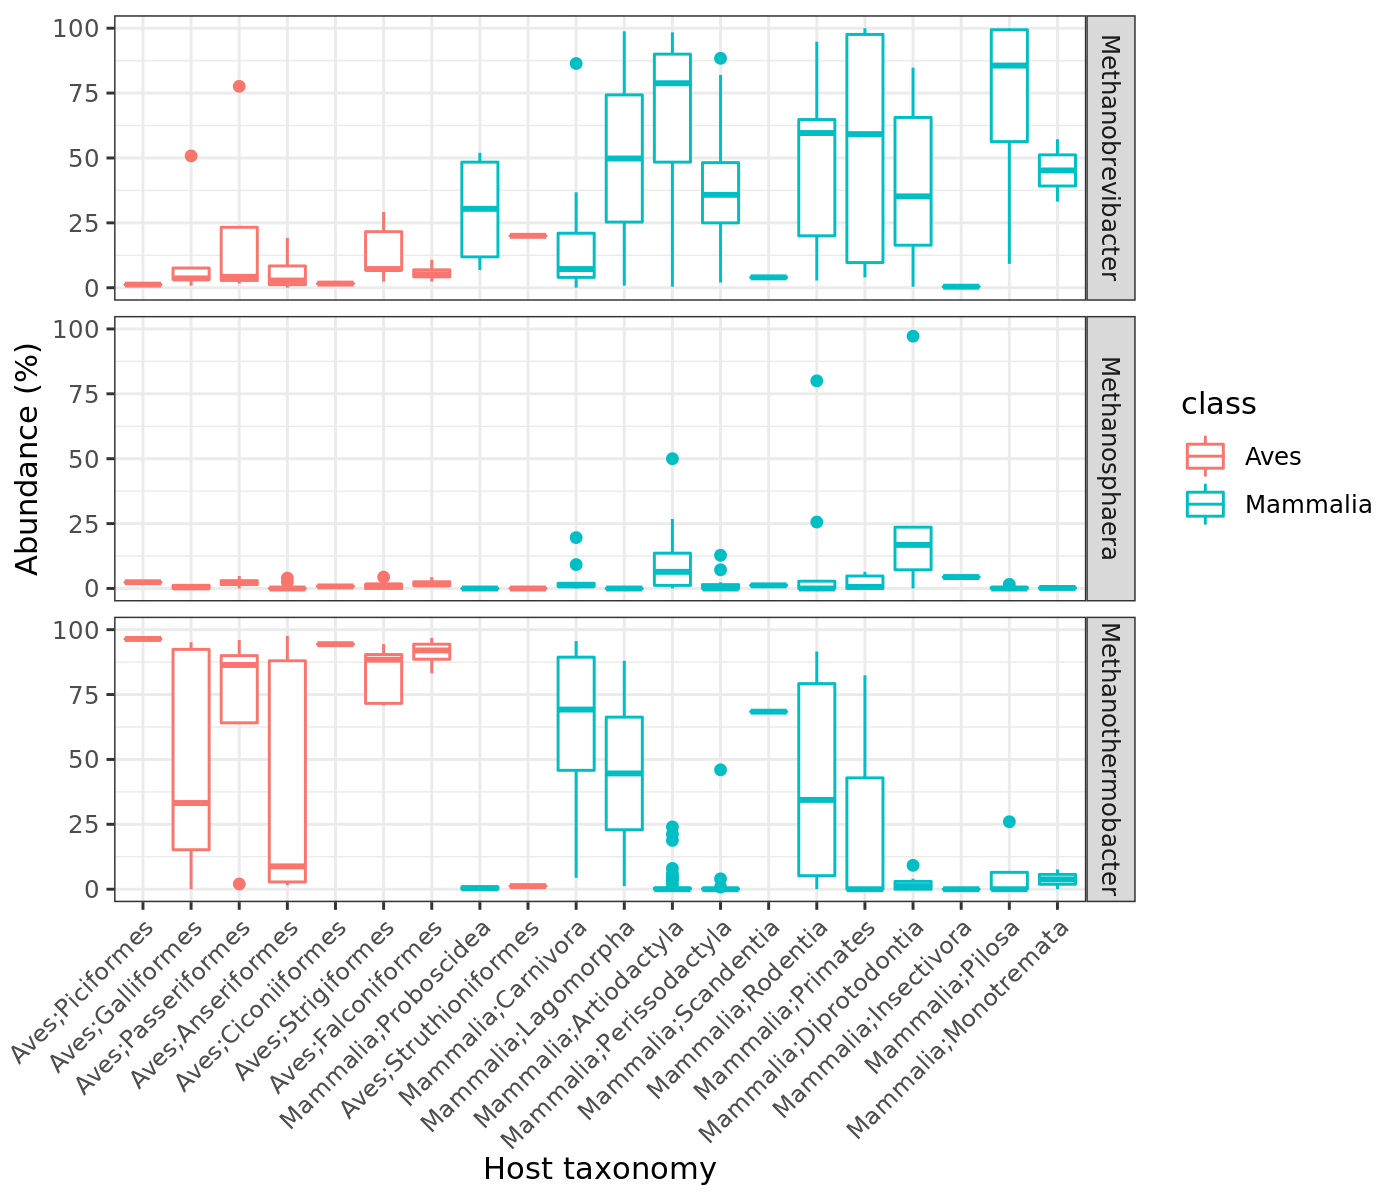

In [21]:
# plotting
p = otu_j %>%
    mutate(host_tax = paste(class, order, sep=';')) %>%
    group_by(host_tax) %>%
    mutate(mean_Tb = mean(Tb)) %>%
    ungroup() %>%
    mutate(host_tax = host_tax %>% reorder(-mean_Tb)) %>%
    ggplot(aes(host_tax, perc_abund, color=class)) +
    geom_boxplot() +
    labs(x='Host taxonomy', y='Abundance (%)') +
    facet_grid(Genus ~ .) +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    )

p.dims(7,6)
plot(p)

# Tree subsample

In [22]:
#' randomly selecting one per group
tree_subsample = function(L, df, tree){
    # get subsample (note: subsampling within each species)
    to_keep = df %>% 
        group_by(scientific_name) %>% 
        sample_n(1) %>%
        .$sample
    # subsampling tree
    to_rm = setdiff(tree$tip.label, to_keep)
    tree = drop.tip(tree, to_rm)
    return(tree)
}

In [23]:
# replicate analyses with different subsets of the host phylogeny
n_reps = 100

In [24]:
# permuted trees
df = metadata %>%
    mutate(sample = SampleID) %>%
    dplyr::select(sample, scientific_name) 

doParallel::registerDoParallel(threads)
host_tree_l = plyr::llply(as.list(1:n_reps), 
                          function(x) tree_subsample(x, df, host_tree),
                          .parallel=TRUE)
host_tree_l %>% length

[1] 100

In [37]:
# samples per permuted tree
host_tree_l %>% lapply(function(x) length(x$tip.label)) %>% as.numeric %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     73      73      73      73      73      73 

# RRPP

In [25]:
.rrpp_per = function(tree, taxon, otu, iter=999){
    # tree
    PhyCov = ape::vcv(tree, model = "Brownian")
    # otu
    otu_f = otu[rownames(PhyCov),]
    data = list(OTUs = otu_f[,taxon] %>% as.matrix,
                Tb = otu_f$Tb)
    names(data[['Tb']]) = rownames(otu_f)
    # rrpp
    fitGLS = lm.rrpp(OTUs ~ Tb, data = data, Cov = PhyCov,
                     print.progress = FALSE, SS.type = "II", iter = iter)
    anova(fitGLS)$table
}

rrpp_per = function(taxon, otu, trees, iter=999){
    df = trees %>% 
        plyr::llply(.rrpp_per, taxon=taxon, otu=otu, iter=iter, .parallel=FALSE) %>%
        do.call(rbind, .) %>%
        mutate(feature = gsub('[0-9]+$', '', rownames(.))) 
    df$taxon = taxon
    return(df)   
}

In [26]:
#running for all OTUs & all trees
taxa = colnames(otu)[2:ncol(otu)]
taxa %>% length %>% cat('Number of OTUs:', ., '\n')

doParallel::registerDoParallel(threads)
rrpp_res = taxa %>%
    plyr::llply(rrpp_per, otu, host_tree_l, iter=999, .parallel=TRUE) %>%
    do.call(rbind, .) %>%
    filter(feature == 'Tb')
rrpp_res

Number of OTUs: 3 


Df,SS,MS,Rsq,F,Z,Pr(>F),feature,taxon
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,31.28695,31.28695,0.014279953,1.0285645,0.5860087,0.314,Tb,b4b7f7c4e6fd5610c4c1fa696408159e
1,15.41254,15.41254,0.004545514,0.3242052,0.1106360,0.536,Tb,b4b7f7c4e6fd5610c4c1fa696408159e
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,1.602282,1.602282,0.008190473,0.5863259,0.3442000,0.450,Tb,X_1f1f87cab902b66753b8bbd81e69a7d4
1,6.152233,6.152233,0.013220676,0.9512441,0.5313634,0.336,Tb,X_1f1f87cab902b66753b8bbd81e69a7d4


## Summary

In [27]:
# formatting
rrpp_res_s = rrpp_res %>%
    rename('P' = `Pr(>F)`) %>%
    group_by(taxon) %>%
    mutate(P = (length(P) - sum(P < 0.05)) / length(P)) %>%
    ungroup() %>%
    mutate(Q = p.adjust(P, method='BH'))

rrpp_res_s %>% .$P %>% summary_x('P')
rrpp_res_s %>% .$Q %>% summary_x('Adj. P')
rrpp_res_s

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,sd,sd_err_of_mean
P,0.99,0.99,1,0.9966667,1,1,0.005,0.002


,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,sd,sd_err_of_mean
Adj. P,1,1,1,1,1,1,0,0


Df,SS,MS,Rsq,F,Z,P,feature,taxon,Q
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,31.28695,31.28695,0.014279953,1.0285645,0.5860087,1,Tb,b4b7f7c4e6fd5610c4c1fa696408159e,1
1,15.41254,15.41254,0.004545514,0.3242052,0.1106360,1,Tb,b4b7f7c4e6fd5610c4c1fa696408159e,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,1.602282,1.602282,0.008190473,0.5863259,0.3442000,0.99,Tb,X_1f1f87cab902b66753b8bbd81e69a7d4,1
1,6.152233,6.152233,0.013220676,0.9512441,0.5313634,0.99,Tb,X_1f1f87cab902b66753b8bbd81e69a7d4,1


In [28]:
# significant taxa
tax = physeq %>%
    phyloseq2df(tax_table) %>%
    mutate(OTU = gsub('^([0-9])', 'X_\\1', OTU))

rrpp_res_s_f = rrpp_res_s %>%
    filter(Q < 0.05) %>%
    inner_join(tax, c('taxon'='OTU'))
rrpp_res_s_f

Df,SS,MS,Rsq,F,Z,P,feature,taxon,Q,Domain,Phylum,Class,Order,Family,Genus,Species
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>


# RRPP: no phy-cov

## RRPP

In [29]:
.rrpp_per = function(tree, taxon, otu, iter=999){
    # tree
    PhyCov = ape::vcv(tree, model = "Brownian")
    # otu
    otu_f = otu[rownames(PhyCov),]
    data = list(OTUs = otu_f[,taxon] %>% as.matrix,
                Tb = otu_f$Tb)
    names(data[['Tb']]) = rownames(otu_f)
    # rrpp
    fitGLS = lm.rrpp(OTUs ~ Tb, data = data, 
                     print.progress = FALSE, SS.type = "II", iter = iter)
    anova(fitGLS)$table
}

rrpp_per = function(taxon, otu, trees, iter=999){
    df = trees %>% 
        plyr::llply(.rrpp_per, taxon=taxon, otu=otu, iter=iter, .parallel=FALSE) %>%
        do.call(rbind, .) %>%
        mutate(feature = gsub('[0-9]+$', '', rownames(.))) 
    df$taxon = taxon
    return(df)   
}

In [30]:
#running for all OTUs & all trees
taxa = colnames(otu)[2:ncol(otu)]
taxa %>% length %>% cat('Number of OTUs:', ., '\n')

doParallel::registerDoParallel(threads)
rrpp_res = taxa %>%
    plyr::llply(rrpp_per, otu, host_tree_l, iter=999, .parallel=TRUE) %>%
    do.call(rbind, .) %>%
    filter(feature == 'Tb')
rrpp_res

Number of OTUs: 3 


Df,SS,MS,Rsq,F,Z,Pr(>F),feature,taxon
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,4247.892,4247.892,0.04405973,3.272423,1.0671950,0.082,Tb,b4b7f7c4e6fd5610c4c1fa696408159e
1,2717.891,2717.891,0.02938029,2.149143,0.9000331,0.143,Tb,b4b7f7c4e6fd5610c4c1fa696408159e
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,15.72821,15.72821,0.003309399,0.2357475,-0.1426766,0.642,Tb,X_1f1f87cab902b66753b8bbd81e69a7d4
1,65.64821,65.64821,0.006442368,0.4603740,0.2698365,0.465,Tb,X_1f1f87cab902b66753b8bbd81e69a7d4


## Summary

In [31]:
# formatting
rrpp_res_s = rrpp_res %>%
    rename('P' = `Pr(>F)`) %>%
    group_by(taxon) %>%
    mutate(P = (length(P) - sum(P < 0.05)) / length(P)) %>%
    ungroup() %>%
    mutate(Q = p.adjust(P, method='BH'))

rrpp_res_s %>% .$P %>% summary_x('P')
rrpp_res_s %>% .$Q %>% summary_x('Adj. P')
rrpp_res_s

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,sd,sd_err_of_mean
P,0,0,0.98,0.66,1,1,0.487,0.199


,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,sd,sd_err_of_mean
Adj. P,0,0,1,0.6666667,1,1,0.491,0.2


Df,SS,MS,Rsq,F,Z,P,feature,taxon,Q
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,4247.892,4247.892,0.04405973,3.272423,1.0671950,0.98,Tb,b4b7f7c4e6fd5610c4c1fa696408159e,1
1,2717.891,2717.891,0.02938029,2.149143,0.9000331,0.98,Tb,b4b7f7c4e6fd5610c4c1fa696408159e,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,15.72821,15.72821,0.003309399,0.2357475,-0.1426766,1,Tb,X_1f1f87cab902b66753b8bbd81e69a7d4,1
1,65.64821,65.64821,0.006442368,0.4603740,0.2698365,1,Tb,X_1f1f87cab902b66753b8bbd81e69a7d4,1


In [32]:
# significant taxa
tax = physeq %>%
    phyloseq2df(tax_table) %>%
    mutate(OTU = gsub('^([0-9])', 'X_\\1', OTU))

rrpp_res_s_f = rrpp_res_s %>%
    filter(Q < 0.05) %>%
    inner_join(tax, c('taxon'='OTU'))
rrpp_res_s_f

Df,SS,MS,Rsq,F,Z,P,feature,taxon,Q,Domain,Phylum,Class,Order,Family,Genus,Species
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,14463.37,14463.37,0.1246208,10.10771,1.622450,0,Tb,X_859b0f9281126ff8d74d751373fd8891,0,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanothermobacteraceae,Methanothermobacter,NA
1,12253.07,12253.07,0.1074308,8.54565,1.475756,0,Tb,X_859b0f9281126ff8d74d751373fd8891,0,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanothermobacteraceae,Methanothermobacter,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,12914.18,12914.18,0.1111213,8.875914,1.561801,0,Tb,X_859b0f9281126ff8d74d751373fd8891,0,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanothermobacteraceae,Methanothermobacter,NA
1,12634.93,12634.93,0.1056683,8.388886,1.546257,0,Tb,X_859b0f9281126ff8d74d751373fd8891,0,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanothermobacteraceae,Methanothermobacter,NA


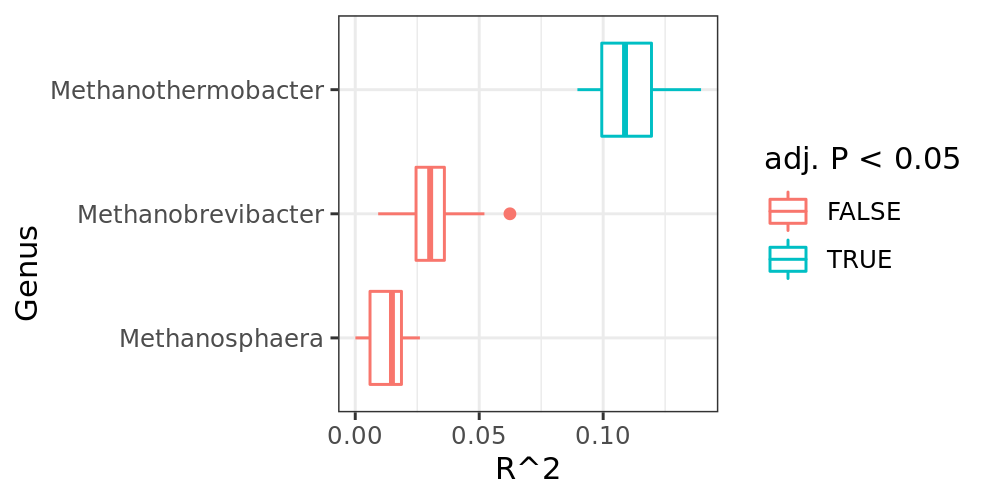

In [33]:
# plotting
p = rrpp_res_s %>%
    mutate(significant = Q < 0.05) %>%
    inner_join(tax, c('taxon'='OTU')) %>%
    mutate(taxon = gsub('^X_', '', taxon)) %>%
    mutate(Taxonomy = paste(Genus, sep='; '),
           Genus = gsub(' ', '\n', Genus),
           Taxonomy = stringr::str_wrap(Taxonomy, 20)) %>%
    group_by(Taxonomy) %>%
    mutate(mean_Rsq = median(Rsq)) %>%
    ungroup() %>%
    mutate(Taxonomy = Taxonomy %>% reorder(mean_Rsq)) %>%
    ggplot(aes(Taxonomy, Rsq, color=significant)) +
    geom_boxplot() +
    scale_color_discrete('adj. P < 0.05') +
    labs(x='Genus', y='R^2') +
    theme_bw() +
    theme(
        axis.title.y = element_text(hjust = 0.3)
    ) +
    coord_flip()

p.dims(5,2.5)
plot(p)

# sessionInfo

In [34]:
sessionInfo()

R version 4.0.0 (2020-04-24)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /ebio/abt3_projects/Georg_animal_feces/envs/phyloseq-physig/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] LeyLabRMisc_0.1.6 doParallel_1.0.15 iterators_1.0.12  foreach_1.5.0    
 [5] RRPP_0.6.0        phyloseq_1.32.0   ape_5.4           ggplot2_3.3.1    
 [9] tidyr_1.1.0       dplyr_1.0.0      

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.4.6      